# 2-D Scatter Plots and Spectral Plots with Wyvern Data
This notebook details how to produce 2-D scatter plots and spectral curve plots with Wyvern data in Python. These plots can be used to understand the various materials, objects, and species of vegetation that are present in an image.

More details can be found on our Knowledge Centre at the following link:

https://knowledge.wyvern.space/#/using_wyvern_data/python/python.md

## Getting started
- Ensure you have installed Anaconda/Conda
- Build the environment for this notebook using the following command:
  ```
   conda env create -f environment.yml
  ```
- Run this notebook in your tool of choice (Jupyter Lab, Visual Studio Code, etc), making sure you run it with the conda environment you just created!

## Image we're using
We're using the image also used in `visualizing_wyvern_data.ipynb`. Check out the renderings of the image there, or
on the [Wyvern Open Data Catalog](https://opendata.wyvern.space/#/year/2024/wyvern_dragonette-001_20240930T070744_08fd7f5a/wyvern_dragonette-001_20240930T070744_08fd7f5a.json)!

## Spectral Plots
These plots show an individual pixel's reflectance/radiance across the electromagnetic spectrum that Wyvern's imagery senses. The spectral curve can be used to visually identify the pixel, and can be used by machine learning (and other methods!) to classify the spectral curve as a particular material/species of vegetation. We will dive into classification methods in another tutorial.

## Scatter Plots
2-dimensional scatter plots showcases the distribution of pixels across different bands. This can be used to group spectrally similar pixels, or identify where a particular pixel lies on the plot.

In [5]:
# First, let's import our required packages
import requests
import rasterio
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Rectangle

In [6]:
# Feel free to modify the STAC item/image that is downloaded in this section
DOWNLOAD_IMAGE = True
STAC_ITEM = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/year/2024/wyvern_dragonette-001_20240930T070744_08fd7f5a/wyvern_dragonette-001_20240930T070744_08fd7f5a.json"
LOCAL_FILE_NAME = "wyvern_dragonette-001_20240930T070744_08fd7f5a.tiff"

In [7]:
print("Loading STAC Item!")
stac_item_response = requests.get(STAC_ITEM)
stac_item_response.raise_for_status()  # Will raise an error if we have any issues getting the STAC item
stac_item = stac_item_response.json()
print(f"Successfully loaded STAC Item!\nSTAC Item ID: {stac_item['id']}")

download_url = stac_item["assets"]["Cloud optimized GeoTiff"]["href"]
local_file_name = download_url.split("/")[-1]
print(
    f"Downloading GeoTIFF from STAC Metadata!\nDownload url: {download_url}]\n"
    f"Downloading to local file named: {local_file_name}"
)

if DOWNLOAD_IMAGE:
    with requests.get(download_url, stream=True) as r:
        r.raise_for_status()
        with open(local_file_name, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
print("Download completed!")

Loading STAC Item!
Successfully loaded STAC Item!
STAC Item ID: wyvern_dragonette-001_20240930T070744_08fd7f5a
Download url: https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240930T070744_08fd7f5a/wyvern_dragonette-001_20240930T070744_08fd7f5a.tiff]
Download completed!


In [8]:
# Now, let's load in our downloaded image & print some metadata about the image.
image_file = rasterio.open(LOCAL_FILE_NAME)
image_arr = image_file.read()

# Replace -9999 w/ NaNs
image_arr = np.where(image_arr == image_file.nodata, np.nan, image_arr)

print(f"Image shape: {image_arr.shape}")
print(f"Image bands: {', '.join(image_file.descriptions)}")

Image shape: (23, 8271, 6013)
Image bands: Band_503, Band_510, Band_519, Band_535, Band_549, Band_570, Band_584, Band_600, Band_614, Band_635, Band_649, Band_660, Band_669, Band_679, Band_690, Band_699, Band_711, Band_722, Band_734, Band_750, Band_764, Band_782, Band_799


# Spectral Curve Plot

In [9]:
def min_max_normalize(arr: np.ndarray) -> np.ndarray:
    """Wyvern L1B data is Top-of-Atmosphere Radiance. These values
    are out of the range that matplotlib is expecting. We need to scale
    our image values to 0-1 or 0-255.

    Args:
        arr (np.ndarray): Input array requiring scaling

    Returns:
        np.ndarray: Scaled output array
    """
    # nanmin/nanmax ignore NaN values within an array while still calculating the value (max, min)
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))

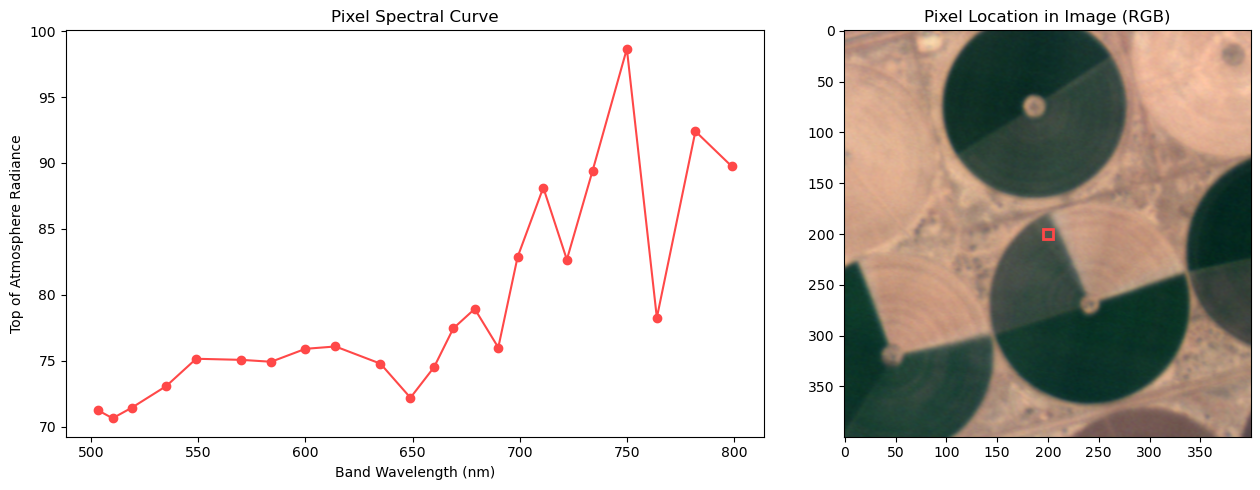

In [10]:
# To plot a spectral curve, we first need to pick a pixel in the image to plot!
PIXEL_X, PIXEL_Y = 1600, 1900  # Point on image to plot, feel free to change!

pixel_spectra = image_arr[:, PIXEL_X, PIXEL_Y]  # Grabbing pixel from image array
band_wavelengths = [
    float(x.split("Band_")[1]) for x in image_file.descriptions
]  # Calculating wavelengths for line plot

# Subplots allows us to plot two things at once! Neat!
fig, axs = plt.subplots(1, 2, figsize=(13, 5), width_ratios=[1.5, 1])

# First, plotting the spectra as a line chart
axs[0].plot(band_wavelengths, pixel_spectra, marker="o", color="#ff4848")
axs[0].set_title("Pixel Spectral Curve")
axs[0].set_xlabel("Band Wavelength (nm)")
axs[0].set_ylabel("Top of Atmosphere Radiance")

# Secondly, plotting a buffered area around our pixel to visualize what we're looking at!
axs[1].imshow(
    min_max_normalize(
        image_arr[
            [10, 4, 0],  # R, G, B
            PIXEL_X - 200 : PIXEL_X + 200,  # Buffering around point
            PIXEL_Y - 200 : PIXEL_Y + 200,  # Buffering around point
        ].swapaxes(
            0, -1
        )  # Moving [Band, X, Y] to [X, Y, Band] shape
    )
)

# We can also add a red box around the pixel we are looking at in the line chart!
pixel_rect = Rectangle(
    (195, 195), 10, 10, linewidth=2, edgecolor="#ff4848", facecolor="none"
)
axs[1].add_patch(pixel_rect)
axs[1].set_title("Pixel Location in Image (RGB)")

plt.tight_layout()
plt.show()

## Spectral Curve Discussion
Note the large downward spike near 760nm. This is an area of the electromagnetic spectrum where oxygen in the earth's atmosphere absorbs light. This means that our satellite receives less information on this band. This is why it is **very** important to perform atmospheric corrections prior to doing any analysis on Wyvern L1B imagery!

# Scatter Plot/Heatmap

## Heatmap Discussion
Heatmap/scatter plots of pixel distributions are useful for discerning different groups of pixels within an image. For example, one group of pixels may be vegetation, while another group of pixels might be dirt or asphalt.

As-generated these plots do not tell us much. We can see a large group of high-reflectance pixels in the centre-ish portion of each plot, with values at a similar level for each band. This group is the dirt/sand around the irrigated fields. Our X-axis on both images is in the near-infrared range, and we can see groups of pixels that have a high X (near-infrared) reflectance, but a low blue/green/red reflectance. These pixels are vegetation, since vegetation has high reflectance in the near-infrared portion of the spectrum, and low reflectance in the blue/green section of the spectrum! We can see some distinct groups in this area (feel free to zoom the plot in to this area!), these groups are likely different species of crops, or crops in different growth stages. How cool!

We could extend these plots by highlighting areas of high-NDVI, or labeling areas with a shapefile and highlighting these areas to identify pixels that have a matching/similar spectra. We'll leave extending this notebook up to you, dear reader :)

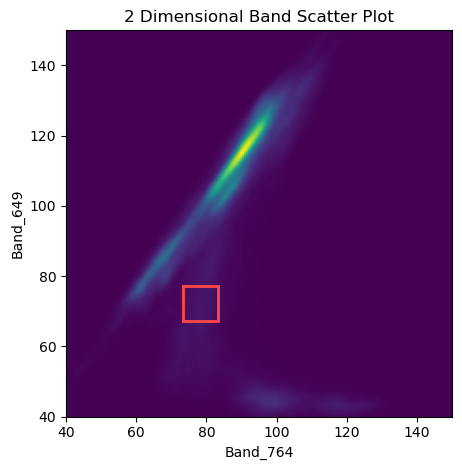

In [13]:
# Now, we're ready to plot some band combinations!
# We'll start out w/ Bands 649nm and 764nm
X_IDX = 20
Y_IDX = 10

# Ravel turns our 2D X-Y image array into a single dimensional array
band_x = image_arr[X_IDX].ravel()
band_y = image_arr[Y_IDX].ravel()

# Here we're filtering out our NaNs from the array
band_x = band_x[~np.isnan(band_x)]
band_y = band_y[~np.isnan(band_y)]

# This generates a two-dimensional histogram, or summary of our data statistics.
# It allows us to plot a "heatmap" of where points lie between two bands.
heatmap, xedges, yedges = np.histogram2d(
    band_x, band_y, bins=200, range=[[40, 150], [40, 150]]
)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# We then can plot our heatmap!
fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin="lower", cmap="viridis")
plt.xlabel(image_file.descriptions[X_IDX])
plt.ylabel(image_file.descriptions[Y_IDX])

# Since we highlighted where our selected pixel was on the image in the above spectral plot, let's
# also highlight where the pixel lies in our scatter plot!
pixel_rect = Rectangle(
    (pixel_spectra[X_IDX] - 5, pixel_spectra[Y_IDX] - 5), 10, 10, linewidth=2, edgecolor="#ff4848", facecolor="none"
)
ax.add_patch(pixel_rect)

plt.title("2 Dimensional Band Scatter Plot")
plt.tight_layout()
plt.show()

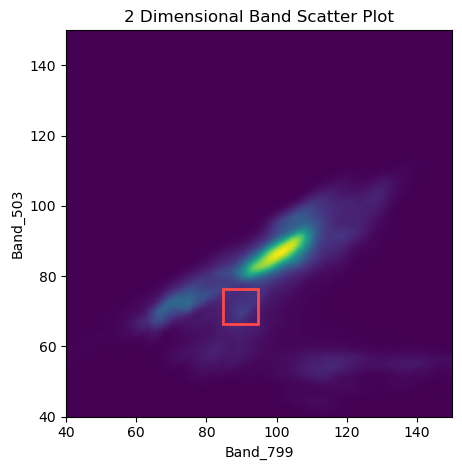

In [14]:
# Let's now do our first and last bands!
X_IDX = 22
Y_IDX = 0

# Ravel turns our 2D X-Y image array into a single dimensional array
band_x = image_arr[X_IDX].ravel()
band_y = image_arr[Y_IDX].ravel()

# Here we're filtering out our NaNs from the array
band_x = band_x[~np.isnan(band_x)]
band_y = band_y[~np.isnan(band_y)]

# This generates a two-dimensional histogram, or summary of our data statistics.
# It allows us to plot a "heatmap" of where points lie between two bands.
heatmap, xedges, yedges = np.histogram2d(
    band_x, band_y, bins=200, range=[[40, 150], [40, 150]]
)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# We then can plot our heatmap!
fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin="lower", cmap="viridis")
plt.xlabel(image_file.descriptions[X_IDX])
plt.ylabel(image_file.descriptions[Y_IDX])

# Since we highlighted where our selected pixel was on the image in the above spectral plot, let's
# also highlight where the pixel lies in our scatter plot!
pixel_rect = Rectangle(
    (pixel_spectra[X_IDX] - 5, pixel_spectra[Y_IDX] - 5), 10, 10, linewidth=2, edgecolor="#ff4848", facecolor="none"
)
ax.add_patch(pixel_rect)

plt.title("2 Dimensional Band Scatter Plot")
plt.tight_layout()
plt.show()